# Starcraft 2 Pro Players compare EDA

![Starcraft 2 Pro Players compare EDA](https://game4u.co.za/wp-content/uploads/SCLOFTVbanner.jpg)

## Table Of Contents:
* [Goal](#first-bullet)
* [Load and clean data](#second-bullet)
* [Historical score](#third-bullet)
* [Opposing race](#fourth-bullet)
* [Each other](#fifth-bullet)
* [TODO](#sixth-bullet)

## Goal <a class="anchor" id="first-bullet"></a>

The goal of this analysis is to compare the main indicators of the two pro players and to understand whether it is possible to conclude from them about the victory or the advantage of one of the players.

## Load and clean data <a class="anchor" id="second-bullet"></a>

Let's load all libraries necessary for us and. And also check for empty values.

In [94]:
# For autoreloading modules
%load_ext autoreload
%autoreload 2
# For notebook plotting
%matplotlib inline

# Standard libraries
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox import pdp
from plotnine import *
from pandas_summary import DataFrameSummary
from IPython.display import display
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
KAGGLE_DIR = '../input/'
data = pd.read_csv(KAGGLE_DIR + 'sc2-matches-history.csv')

Display first five rows and last 5 rows.

In [86]:
print('First 5 rows: ')
display(data.head())

print('Last 5 rows: ')
display(data.tail())

First 5 rows: 


,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type
0,09/19/2016,MC,[loser],0–2,Stats,[winner],P,P,LotV,online
1,09/19/2016,MC,[winner],2–1,NaTuRal,[loser],P,T,LotV,online
2,09/19/2016,MC,[loser],1–2,Dark,[winner],P,Z,LotV,online
3,09/13/2016,MC,[loser],0–2,INnoVation,[winner],P,T,LotV,online
4,08/27/2016,MC,[loser],0–1,TRUE,[winner],P,Z,LotV,online


Last 5 rows: 


,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type
374789,07/06/2012,Sabre,[loser],0–2,Dez,[winner],Z,P,WoL,online
374790,07/06/2012,Sabre,[winner],2–1,Stolensheep,[loser],Z,Z,WoL,online
374791,06/07/2012,Sabre,[loser],0–2,Jimmeh,[winner],Z,T,WoL,online
374792,06/07/2012,Sabre,[winner],2–0,Niacim,[loser],Z,P,WoL,online
374793,10/26/2011,Sabre,[loser],0–2,Pjonkan,[winner],T,P,WoL,online


In [87]:
data.describe()

,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type
count,374794,374794,374794,374794,374793,374794,374794,374794,374794,374794
unique,2733,1856,2,93,10801,2,4,4,3,2
top,04/11/2015,Bly,[winner],2–0,Bly,[loser],Z,Z,HotS,online
freq,783,3932,206918,93890,3494,205898,146348,143034,152754,297507


Now we see that in the player_2 column there is an empty value. Let's look at it and delete it.

In [88]:
display(data[data['player_2'].isnull()])

,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type
85860,08/29/2010,Kas,[winner],2–0,NaN,[loser],T,Z,WoL,online


In [89]:
data.drop(85860, inplace=True)

Chek it again.

In [90]:
display(data[data['player_2'].isnull()])

,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type


For comparison, we take two Ukrainian pro players [Bly](https://liquipedia.net/starcraft2/Bly) and [Kas](https://liquipedia.net/starcraft2/Kas) and form a data frame on them.

![Bly vs Kas](https://i.ytimg.com/vi/qQWacD67slk/maxresdefault.jpg)


In [92]:
all_data = data[(data['player_1']=='Bly') | (data['player_1']=='Kas')]

display(all_data.head(10))

display(all_data.tail(10))

,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type
64342,10/18/2017,Bly,[loser],1–3,Solar,[winner],Z,Z,LotV,online
64343,10/18/2017,Bly,[winner],2–0,Creed,[loser],Z,T,LotV,online
64344,10/18/2017,Bly,[winner],2–0,Crowbar,[loser],Z,Z,LotV,online
64345,10/16/2017,Bly,[loser],2–3,Hellraiser,[winner],Z,P,LotV,online
64346,10/16/2017,Bly,[winner],2–0,Minato,[loser],Z,Z,LotV,online
64347,10/16/2017,Bly,[winner],2–0,Prince,[loser],Z,P,LotV,online
64348,10/16/2017,Bly,[winner],2–0,Overmind,[loser],Z,Z,LotV,online
64349,10/15/2017,Bly,[loser],0–2,KeeN,[winner],Z,T,LotV,online
64350,10/15/2017,Bly,[winner],2–0,Voltz,[loser],Z,Z,LotV,online
64351,10/15/2017,Bly,[winner],2–0,Rail,[loser],Z,P,LotV,online


,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type
85870,05/08/2010,Kas,[loser],0–1,MuHi,[winner],T,P,WoL,online
85871,05/01/2010,Kas,[winner],1–0,DarKFoRcE,[loser],T,Z,WoL,online
85872,05/01/2010,Kas,[winner],2–1,NaNiwa,[loser],T,P,WoL,online
85873,05/01/2010,Kas,[winner],2–0,LaLuSh,[loser],T,Z,WoL,online
85874,05/01/2010,Kas,[loser],0–2,Tarson,[winner],T,T,WoL,online
85875,04/11/2010,Kas,[winner],1–0,BeNSeN,[loser],T,Z,WoL,online
85876,04/11/2010,Kas,[loser],0–2,MaNa,[winner],T,P,WoL,online
85877,03/31/2010,Kas,[winner],2–0,pLaGuE,[loser],T,T,WoL,online
85878,03/31/2010,Kas,[winner],2–0,DeViL,[loser],T,Z,WoL,online
85879,03/31/2010,Kas,[loser],0–3,HasuObs,[winner],T,P,WoL,online


We will be interested only in games in LotV, since all games are played on it.

In [93]:
all_data = all_data[all_data['addon']=='LotV']

Check the data types of our columns. In the date_ column, it is important for us that there be a date. This is necessary to analyze the latest matches.

In [95]:
all_data.dtypes

match_date               object
player_1                 object
player_1_match_status    object
score                    object
player_2                 object
player_2_match_status    object
player_1_race            object
player_2_race            object
addon                    object
tournament_type          object
dtype: object

In [96]:
all_data['match_date'] =pd.to_datetime(all_data['match_date'],dayfirst=False)

In [97]:
all_data.dtypes

match_date               datetime64[ns]
player_1                         object
player_1_match_status            object
score                            object
player_2                         object
player_2_match_status            object
player_1_race                    object
player_2_race                    object
addon                            object
tournament_type                  object
dtype: object

## Historical score <a class="anchor" id="third-bullet"></a>

Let's look at how well the players play historically in the LotV.

In [98]:
data_df = (all_data.melt('player_1')
       .groupby(['player_1','variable'])['value']
       .value_counts()
       .unstack([1,2], fill_value=0)
       .rename_axis((None, None), 1))

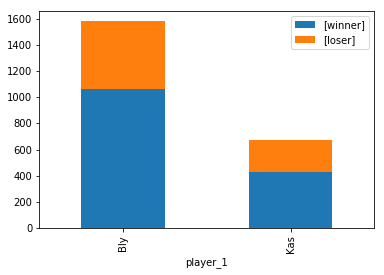

In [100]:
data_df['player_1_match_status'].plot(kind='bar', stacked=True)

**Сonclusion:**

Bly played a lot more matches than Kas in LotV. But from this graph is not quite clear winrate. Need to see the winrate.

In [103]:
all_state_pcts = (all_data.melt('player_1_match_status')
       .groupby(['player_1_match_status','variable'])['value']
       .value_counts()
       .unstack([1,2], fill_value=0)
       .rename_axis((None, None), 1)).apply(lambda x:
                                                 100 * x / float(x.sum()))

In [104]:
all_state_pcts = all_state_pcts['player_1'].transpose()

In [105]:
all_state_pcts = all_state_pcts[['[winner]','[loser]']]

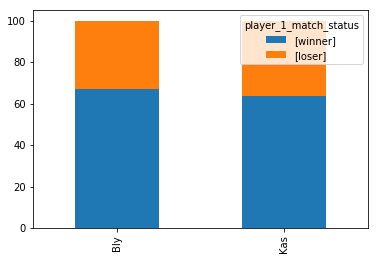

In [106]:
all_state_pcts.plot(kind='bar', stacked=True)

**Сonclusion:**

Now we can conclude that Bly played twice as many games as Kas in the LotV, but at the same time both players' winrate is very close.

Additionally, we’ll see the last 5 games to draw a conclusion on the current form of both players.

In [108]:
data_df_5 = (all_data.groupby('player_1').head(5).melt('player_1')
       .groupby(['player_1','variable'])['value']
       .value_counts()
       .unstack([1,2], fill_value=0)
       .rename_axis((None, None), 1))

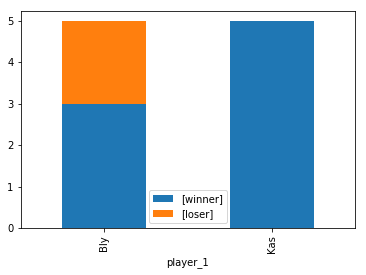

In [109]:
data_df_5['player_1_match_status'].plot(kind='bar', stacked=True)

**Сonclusion:**

The last 5 games, Kas did not lose at the same time, Bly has two defeats. We can assume that Kas is in better form.

## Opposing race <a class="anchor" id="fourth-bullet"></a>

In Starcraft 2, it often happens that a player can play very well against some particular race. Сheck how both players play against the opponent's race.

Let's start with Bly

In [111]:
bly_opposing_race = all_data[(all_data['player_1']=='Bly') & (all_data['player_2_race']=='T')]

display(bly_opposing_race.head(10))

,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type
64343,2017-10-18,Bly,[winner],2–0,Creed,[loser],Z,T,LotV,online
64349,2017-10-15,Bly,[loser],0–2,KeeN,[winner],Z,T,LotV,online
64357,2017-10-12,Bly,[winner],2–0,souL,[loser],Z,T,LotV,online
64360,2017-10-11,Bly,[loser],0–3,aLive,[winner],Z,T,LotV,online
64361,2017-10-11,Bly,[winner],2–0,Lillekanin,[loser],Z,T,LotV,online
64362,2017-10-11,Bly,[winner],2–0,Azure,[loser],Z,T,LotV,online
64363,2017-10-10,Bly,[loser],0–2,KeeN,[winner],Z,T,LotV,online
64366,2017-10-09,Bly,[winner],3–0,Clem,[loser],Z,T,LotV,online
64367,2017-10-09,Bly,[winner],2–1,KeeN,[loser],Z,T,LotV,online
64373,2017-10-08,Bly,[winner],2–0,Kas,[loser],Z,T,LotV,online


In [113]:
bly_pcts = (bly_opposing_race.melt('player_1_match_status')
       .groupby(['player_1_match_status','variable'])['value']
       .value_counts()
       .unstack([1,2], fill_value=0)
       .rename_axis((None, None), 1)).apply(lambda x:
                                                 100 * x / float(x.sum()))

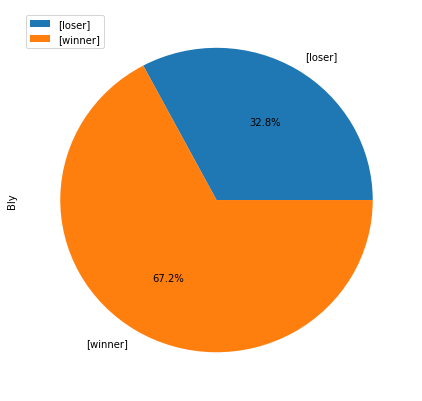

In [121]:
bly_pcts['player_1'].plot.pie(y='Bly', autopct='%1.1f%%',figsize=(7, 7))

Just see the last 5 games

In [122]:
bly_pcts_5 = (bly_opposing_race.groupby('player_1').head(5).melt('player_1_match_status')
       .groupby(['player_1_match_status','variable'])['value']
       .value_counts()
       .unstack([1,2], fill_value=0)
       .rename_axis((None, None), 1)).apply(lambda x:
                                                 100 * x / float(x.sum()))

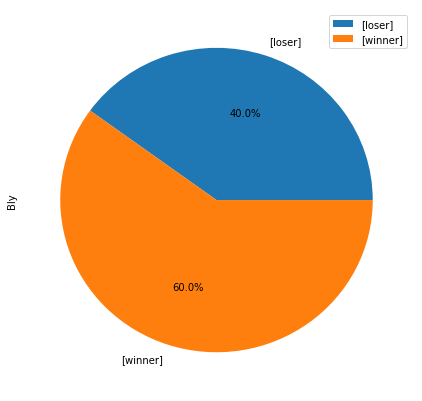

In [123]:
bly_pcts_5['player_1'].plot.pie(y='Bly', autopct='%1.1f%%',figsize=(7, 7))

Now let's see the same thing with Kas.

In [124]:
kas_opposing_race = all_data[(all_data['player_1']=='Kas') & (all_data['player_2_race']=='Z')]

display(kas_opposing_race.head(10))

,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type
83578,2017-10-15,Kas,[winner],2–0,DIMAGA,[loser],T,Z,LotV,online
83580,2017-10-15,Kas,[winner],1–0,fallenger,[loser],T,Z,LotV,online
83584,2017-10-08,Kas,[loser],0–2,Bly,[winner],T,Z,LotV,online
83585,2017-10-08,Kas,[winner],2–0,Lambo,[loser],T,Z,LotV,online
83589,2017-10-07,Kas,[loser],0–2,Zalazane,[winner],T,Z,LotV,online
83591,2017-10-06,Kas,[winner],2–0,hinO,[loser],T,Z,LotV,online
83592,2017-10-06,Kas,[winner],2–1,TomikuS,[loser],T,Z,LotV,online
83593,2017-10-06,Kas,[winner],2–1,Overmind,[loser],T,Z,LotV,online
83600,2017-10-02,Kas,[loser],1–2,Garitos,[winner],T,Z,LotV,online
83601,2017-10-01,Kas,[loser],1–3,DIMAGA,[winner],T,Z,LotV,online


In [125]:
kas_pcts = (kas_opposing_race.melt('player_1_match_status')
       .groupby(['player_1_match_status','variable'])['value']
       .value_counts()
       .unstack([1,2], fill_value=0)
       .rename_axis((None, None), 1)).apply(lambda x:
                                                 100 * x / float(x.sum()))

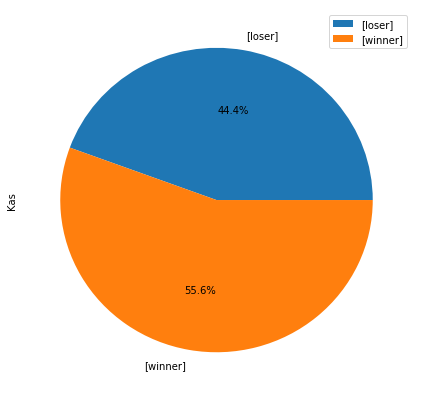

In [126]:
kas_pcts['player_1'].plot.pie(y='Kas', autopct='%1.1f%%',figsize=(7, 7))

In [128]:
kas_pcts_5 = (kas_opposing_race.groupby('player_1').head(5).melt('player_1_match_status')
       .groupby(['player_1_match_status','variable'])['value']
       .value_counts()
       .unstack([1,2], fill_value=0)
       .rename_axis((None, None), 1)).apply(lambda x:
                                                 100 * x / float(x.sum()))

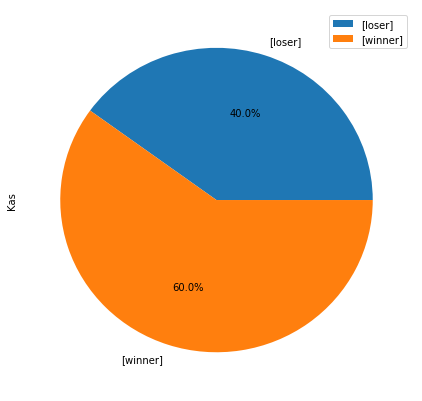

In [129]:
kas_pcts_5['player_1'].plot.pie(y='Kas', autopct='%1.1f%%',figsize=(7, 7))

**Сonclusion:**

Winrate in the last 5 games of the players' wallpaper is the same.  It is noticeable that Bly plays well enough against the Terrans and has a high win rate.

## Each other <a class="anchor" id="fifth-bullet"></a>

A very important indicator is the history of the games of the players with each other. Perhaps some of the players are more in a position to play against another.

We’ll look at Blyu’s statistics, Kas’s statistics are simply inverted data.

In [130]:
against_data = all_data[(all_data['player_1']=='Bly') &(all_data['player_2']=='Kas')]

In [131]:
df = (against_data.melt('player_1_match_status')
       .groupby(['player_1_match_status','variable'])['value']
       .value_counts()
       .unstack([1,2], fill_value=0)
       .rename_axis((None, None), 1))

In [132]:
state_pcts = df['player_1'].groupby(level=0).apply(lambda x:
                                                 100 * x / float(df['player_1'].sum()))

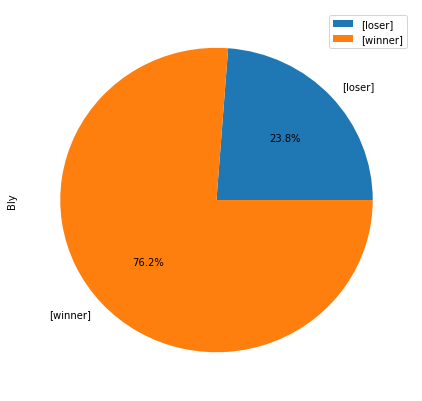

In [134]:
state_pcts.plot.pie(y='Bly', autopct='%1.1f%%',figsize=(7, 7))

In [135]:
df_5 = (against_data.nlargest(5, 'match_date').melt('player_1_match_status')
       .groupby(['player_1_match_status','variable'])['value']
       .value_counts()
       .unstack([1,2], fill_value=0)
       .rename_axis((None, None), 1))

In [136]:
state_pcts_5 = df_5['player_1'].groupby(level=0).apply(lambda x:
                                                 100 * x / float(df_5['player_1'].sum()))

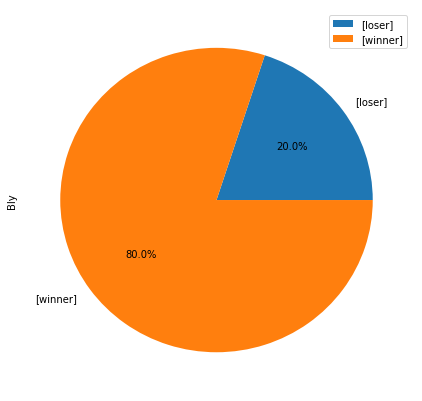

In [137]:
state_pcts_5.plot.pie(y='Bly', autopct='%1.1f%%', figsize=(7, 7))

**Сonclusion:**

It is absolutely clear that Bly, both historically and in the last 5 matches, is stronger than his opponent.

### Final conclusion
As can be seen from the analysis, Bly is a more experienced LotV player than Kas. Historically and after the game, Bly beat his opponent more often. Bly also has a good win rate against his opponent's race. As a result, in the confrontation of Bly and Kas, I prefer the first.

## TODO <a class="anchor" id="sixth-bullet"></a>

1. Make features to view information on any two players.
1.  It is necessary to take into account when analyzing the match score
1.  Add feature - patch. The balance of the game depends on the patch very much and how the players adapt to it
1.  Build a model for forecasting